In [3]:
from tickers import get_ticker
import indicators
import pandas as pd
import math

params = [
    'Z-Score 1', 'Z-Score 2', 'Z-Score 3', 'Stochastic', 'Volume Change 1','Volume Change 2','Recent Change'
]

def generate_df(symbol: str, from_date_string: str):
    df = get_ticker(symbol, from_date_string)
    df['Target'] = df['Close'].shift(-10) - df['Close']
    df['Z-Score 1'] = indicators.z_score(df['Close'], 150)
    df['Z-Score 2'] = indicators.z_score(df['Close'], 70)
    df['Z-Score 3'] = indicators.z_score(df['Close'], 30)
    df['Stochastic'] = indicators.stochastic(df['Close'], df['High'], df['Low'], 14, 3)
    df['Volume Change 1'] = df['Volume']/df['Volume'].shift(5)
    df['Volume Change 2'] = df['Volume']/df['Volume'].shift(1)
    df['Recent Change'] = df['Close'] - df['Close'].shift(10)
    return df


In [4]:
from torch import nn
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(len(params), 16),
            nn.Linear(16, 3),
            nn.Linear(3, 1)
        )
    def forward(self, x):
        return self.stack(x)
    

Using device: cpu


In [5]:
from torch.utils.data import Dataset
from torch import Tensor

class MyDataset(Dataset):
    def __init__(self, source: pd.DataFrame):
        source.dropna(inplace=True)
        self.date = source.index.values
        self.close = source['Close'].values.astype('float32')
        self.input = Tensor(source[params].astype('float32').values)
        self.target = Tensor(source['Target'].astype('float32').values)
    def __len__(self):
        return len(self.input)
    def __getitem__(self, index):
        return self.input[index], self.target[index], str(self.date[index]), self.close[index]
    
whole_dataset = MyDataset(generate_df('SPY', '2021-04-02'))

Obtaining SPY from remote.


In [23]:
from torch.optim import Optimizer
def train(dataloader, model: nn.Module, loss_fn, optim_fn: Optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y, _, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred.flatten(), y)
        
        optim_fn.zero_grad()
        loss.backward()
        optim_fn.step()
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'Loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
            
def test(dataloader, model: nn.Module, l_entries: list | None = None):
    model.eval()
    money, entries, bh_money, bh_entries, accurate_predictions = 0, 0, 0, 0, 0
    
    bullish_predictions, bullish_actuals = 0, 0
    
    with torch.no_grad():
        for X, y, DATES, CLOSES in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).flatten()
            for prediction, actual, date, close in zip(pred, y, DATES, CLOSES):
                bh_money += actual
                bh_entries += 1
                if math.copysign(1, prediction) == math.copysign(1, actual):
                    accurate_predictions += 1
                if prediction > 0:
                    if l_entries is not None:
                        l_entries.append((date, close.item()))
                    money += actual
                    entries += 1
                    bullish_predictions += 1
                    if actual > 0:
                        bullish_actuals += 1
    print(f'Forecast Directional Accuracy: {100*accurate_predictions/bh_entries:.2f}%')
    print(f'Bullish Forecast Directional Accuracy: {100*bullish_actuals/bullish_predictions:.2f}%')
    print(f'Model Money: ${money:.2f} ({entries} entries)')
    print(f'BuyHold Money: ${bh_money:.2f} ({bh_entries} entries)')

In [152]:
from torch import optim
from torch.utils.data import DataLoader, random_split

model = Model().to(device)
loss_fn = nn.MSELoss()
optim_fn = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_dataset, test_dataset = random_split(whole_dataset, [0.7, 0.3])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

for epoch in range(1_000):
    print(f'Epoch: {epoch+1}')
    train(train_dataloader, model, loss_fn, optim_fn)
    test(train_dataloader, model)
    
    

Epoch: 1
Loss: 261.966125 [    0/  418]
Model Money: $255.24 (418 entries)
BuyHold Money: $255.24 (418 entries)
Epoch: 2
Loss: 236.080887 [    0/  418]
Model Money: $203.50 (238 entries)
BuyHold Money: $255.24 (418 entries)
Epoch: 3
Loss: 175.753510 [    0/  418]
Model Money: $137.50 (208 entries)
BuyHold Money: $255.24 (418 entries)
Epoch: 4
Loss: 230.850311 [    0/  418]
Model Money: $159.97 (255 entries)
BuyHold Money: $255.24 (418 entries)
Epoch: 5
Loss: 233.306458 [    0/  418]
Model Money: $255.24 (418 entries)
BuyHold Money: $255.24 (418 entries)
Epoch: 6
Loss: 250.825867 [    0/  418]
Model Money: $299.72 (408 entries)
BuyHold Money: $255.24 (418 entries)
Epoch: 7
Loss: 194.323227 [    0/  418]
Model Money: $470.19 (344 entries)
BuyHold Money: $255.24 (418 entries)
Epoch: 8
Loss: 169.984222 [    0/  418]
Model Money: $257.02 (280 entries)
BuyHold Money: $255.24 (418 entries)
Epoch: 9
Loss: 182.161606 [    0/  418]
Model Money: $255.24 (418 entries)
BuyHold Money: $255.24 (418 e

In [153]:
torch.save(model.state_dict(), f'models/{hash('_'.join(params))}')

TXN data found in cache.
Forecast Directional Accuracy: 58.63%
Bullish Forecast Directional Accuracy: 57.01%
Model Money: $266.73 (335 entries)
BuyHold Money: $-184.07 (597 entries)
                                     Date       Close
Date                                                 
2024-03-13  2024-03-13T00:00:00.000000000  172.679993
2024-03-14  2024-03-14T00:00:00.000000000  171.139999
2024-03-18  2024-03-18T00:00:00.000000000  169.210007
2024-03-19  2024-03-19T00:00:00.000000000  166.759995
2024-03-20  2024-03-20T00:00:00.000000000  169.979996


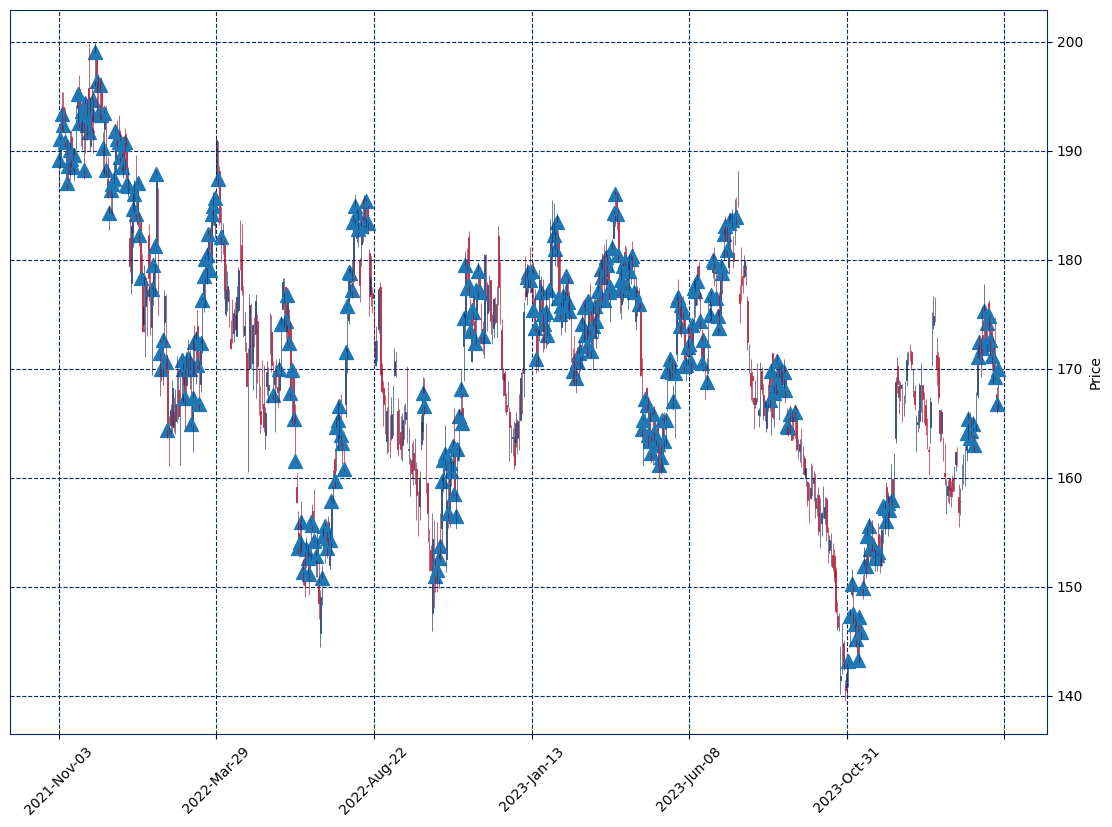

In [44]:
from torch.utils.data import DataLoader
import mplfinance as mpf
import numpy as np

eval_df = generate_df("TXN", "2021-04-03")
eval_model = Model().to(device)
eval_model.load_state_dict(torch.load('models/6058076314007640158'))
eval_dataloader = DataLoader(MyDataset(eval_df))
entries = []
test(eval_dataloader, eval_model, entries)
entries_df = pd.DataFrame(entries, columns=['Date', 'Close'])
entries_df.index = pd.to_datetime(entries_df['Date'])
eval_df['Entries'] = np.nan
for date, close in zip(pd.to_datetime(entries_df.index), entries_df['Close']):
    eval_df.loc[date, 'Entries'] = close
print(entries_df.tail())

inds_dict = [
    mpf.make_addplot(eval_df['Entries'], type='scatter', markersize=30),
]


mpf.plot(eval_df, 
         type='candle', 
         addplot=inds_dict,
         volume=False,
         style='sas',
         figscale=1.8,
         warn_too_much_data=10**10
         )


